<h1 id="tocheading">Оглавление</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.

**Инструкция по выполнению проекта**

* Загрузите и подготовьте данные. Поясните порядок действий.
* Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.
* Улучшите качество модели, учитывая дисбаланс классов. Обучите разные модели и найдите лучшую. Кратко опишите выводы.
* Проведите финальное тестирование.


**Описание данных**

Данные находятся в файле /datasets/Churn.csv (англ. «отток клиентов»). 

Признаки:
* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — сколько лет человек является клиентом банка
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата
* Целевой признак
* Exited — факт ухода клиента

# Изучение и подготовка данных

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from tqdm import notebook as tqdm

In [3]:
df = pd.read_csv('/filename.csv')



In [4]:
#это служебная функция для запуска progress-bar - индикатора статуса процесса
def improve_guess(rt, n):
    return (rt + n/rt) / 2

In [5]:
display(df.shape)

(10000, 14)

In [6]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

Пропуски есть только в одном столбце. С типами переменных на первый взгляд, все в порядке.

In [7]:
display(df.head(10))

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [8]:
display(df.describe())#посмотрим описательные статистики для оцнки возможных аномалий и выбросов

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Можно отметить, что большое количество клиентов (25% от общего числа) имеют нулевой баланс, не имеют карты банка.

In [9]:
#функция для вывода уникальных значений по каждому столбцу:
def check_columns(df):
    for column in df.columns:
        display('Уникальные значения столбца {}:'.format(column))
        display(df[column].unique())
        
check_columns(df)

'Уникальные значения столбца RowNumber:'

array([    1,     2,     3, ...,  9998,  9999, 10000])

'Уникальные значения столбца CustomerId:'

array([15634602, 15647311, 15619304, ..., 15584532, 15682355, 15628319])

'Уникальные значения столбца Surname:'

array(['Hargrave', 'Hill', 'Onio', ..., 'Kashiwagi', 'Aldridge',
       'Burbidge'], dtype=object)

'Уникальные значения столбца CreditScore:'

array([619, 608, 502, 699, 850, 645, 822, 376, 501, 684, 528, 497, 476,
       549, 635, 616, 653, 587, 726, 732, 636, 510, 669, 846, 577, 756,
       571, 574, 411, 591, 533, 553, 520, 722, 475, 490, 804, 582, 472,
       465, 556, 834, 660, 776, 829, 637, 550, 698, 585, 788, 655, 601,
       656, 725, 511, 614, 742, 687, 555, 603, 751, 581, 735, 661, 675,
       738, 813, 657, 604, 519, 664, 678, 757, 416, 665, 777, 543, 506,
       493, 652, 750, 729, 646, 647, 808, 524, 769, 730, 515, 773, 814,
       710, 413, 623, 670, 622, 785, 605, 479, 685, 538, 562, 721, 628,
       668, 828, 674, 625, 432, 770, 758, 795, 686, 789, 589, 461, 584,
       579, 663, 682, 793, 691, 485, 650, 754, 535, 716, 539, 706, 586,
       631, 717, 800, 683, 704, 615, 667, 484, 480, 578, 512, 606, 597,
       778, 514, 525, 715, 580, 807, 521, 759, 516, 711, 618, 643, 671,
       689, 620, 676, 572, 695, 592, 567, 694, 547, 594, 673, 610, 767,
       763, 712, 703, 662, 659, 523, 772, 545, 634, 739, 771, 68

'Уникальные значения столбца Geography:'

array(['France', 'Spain', 'Germany'], dtype=object)

'Уникальные значения столбца Gender:'

array(['Female', 'Male'], dtype=object)

'Уникальные значения столбца Age:'

array([42, 41, 39, 43, 44, 50, 29, 27, 31, 24, 34, 25, 35, 45, 58, 32, 38,
       46, 36, 33, 40, 51, 61, 49, 37, 19, 66, 56, 26, 21, 55, 75, 22, 30,
       28, 65, 48, 52, 57, 73, 47, 54, 72, 20, 67, 79, 62, 53, 80, 59, 68,
       23, 60, 70, 63, 64, 18, 82, 69, 74, 71, 76, 77, 88, 85, 84, 78, 81,
       92, 83])

'Уникальные значения столбца Tenure:'

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

'Уникальные значения столбца Balance:'

array([     0.  ,  83807.86, 159660.8 , ...,  57369.61,  75075.31,
       130142.79])

'Уникальные значения столбца NumOfProducts:'

array([1, 3, 2, 4])

'Уникальные значения столбца HasCrCard:'

array([1, 0])

'Уникальные значения столбца IsActiveMember:'

array([1, 0])

'Уникальные значения столбца EstimatedSalary:'

array([101348.88, 112542.58, 113931.57, ...,  42085.58,  92888.52,
        38190.78])

'Уникальные значения столбца Exited:'

array([1, 0])

In [10]:
display(df.duplicated().sum())#проверим, есть ли дубли

0

In [11]:
df.columns = df.columns.str.lower()#приведем названия признаков к нижнму регистру

Посмотрим на столбец с нулевыми значениями.

In [12]:
display('Пропущенных значений в признаке tenure: {:.2%}'.format(df['tenure'].isnull()
                                           .sum()/df['tenure'].shape[0]))

display(df[df['tenure'].isnull()])

'Пропущенных значений в признаке tenure: 9.09%'

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


Количество объектов с пропусками в столбце 'tenure'  составляет около 9% от всей выборки. 

На первый взгляд, сложно определеить причину пропуска в данных и решить, что делать с пропусками. 

Возможно, пропуски связаны с тем, что пользователи стали клиентами менее года назад. 

Решено заменить пропуски на 0.

In [13]:
df['tenure'] = df['tenure'].fillna(0)
display(df.info())#проверка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           10000 non-null  float64
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

Удалим столбецы RowNumber, CustomerId и Surname. Они не нужны при исследовании модели.

RowNumber повторяет индекс датафрейма, CustomerId - случайный или последовательный номер, который никак не зависит от действий пользователя. Surname - признак, который отличается от человека к человеку и является именем в обществе. Это не гарант того, что клиент останется или уйдет.

In [14]:
df = df.drop(['rownumber','customerid','surname'], axis=1)
df.shape

(10000, 11)

## Вывод

Мы провели изучение и предобработку данных: привели названия столбцов к нижнему регистру, заполнили пропуски в столбце 'tenure'. Других проблем с данными не обнаружено.

# Изучение баланса классов, обучение модели без учёта дисбаланса

Создадим датафрейм, созданный по методу прямого кодирования с защитой от дамми-ловушки.

In [15]:
ohe_df = pd.get_dummies(df, drop_first=True)
display(ohe_df.columns.value_counts())

gender_Male          1
age                  1
geography_Spain      1
estimatedsalary      1
balance              1
exited               1
creditscore          1
tenure               1
geography_Germany    1
numofproducts        1
hascrcard            1
isactivemember       1
dtype: int64

Будем использовать следующие модели:

Логистическая регрессия
Случайный лес
Решающее дерево

Разобъем данные по принципу 60/20/20.

In [16]:
target = ohe_df['exited']
features = ohe_df.drop('exited', axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, 
                                                                              random_state=20052020)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, 
                                                                              random_state=20052020 )
display(features_train.shape, features_valid.shape, features_test.shape)
display(target_train.shape, target_valid.shape, target_test.shape)

(6000, 11)

(2000, 11)

(2000, 11)

(6000,)

(2000,)

(2000,)

In [17]:
target.value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

Имеется дисбаланс классов в целевом признаке! Метрика Accuracy становится нерелевантной.



**Сперва обучим и сравним качество моделей без работы с дисбалансом классов.**

In [18]:
random = 123 #вынесли random_state в отдельную переменную, чтобы не ошибиться и не указать разный

Первая модель - Дерево решений. Подбор оптимальных гиперпараметров доверим методу GridSearchCV.

In [19]:
#создаем словарь гиперпараметров для работы метода GridSearchCV
max_depth = range(1, 10)

min_samples_split = range(2, 5, 1)

max_features = ['sqrt']

min_samples_leaf = range(1, 5)

space = { 'max_features': max_features,
          'max_depth': max_depth,
          'min_samples_split': min_samples_split,
          'min_samples_leaf': min_samples_leaf }

In [20]:
model = DecisionTreeClassifier(random_state=random)
search = GridSearchCV(model, space, scoring = 'f1')
search.fit(features_train, target_train)
print(search.best_params_)

{'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}


Лучший результат был достигнут на глубине 7, min_samples_leaf == 1, min_samples_split == 2.

Рассмотрим, как себя ведет случайный лес. Подбор оптимальных гиперпараметров также доверим методу GridSearchCV.

In [21]:
#добавим в словарь гиперпараметров n_estimators
n_estimators = range(1,10)

space = { 'n_estimators': n_estimators,
          'max_features': max_features,
          'max_depth': max_depth,
          'min_samples_split': min_samples_split,
          'min_samples_leaf': min_samples_leaf }

In [22]:
model = RandomForestClassifier(random_state=random)
search = GridSearchCV(model, space, scoring = 'f1')
search.fit(features_train, target_train)
print(search.best_params_)

{'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 5}


Подобрали оптимальные гиперпараметры для Случайного леса.

Третья модель для тестирования - Логистическая регрессия.

In [23]:
%%time

model =  LogisticRegression(random_state=random, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('F1', f1_score(target_valid, predicted_valid).round(4))

F1 0.0922
CPU times: user 65.1 ms, sys: 24 ms, total: 89.1 ms
Wall time: 75.6 ms


Проведем сравнительную оценку accuracy, precision и recall, также покажем F1-меру.

In [24]:
model = DecisionTreeClassifier(random_state=random, max_depth=7, min_samples_leaf=1, min_samples_split=2)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Дерево решений:')
print('Accuracy', accuracy_score(target_valid, predicted_valid).round(4))
print('Precision', precision_score(target_valid, predicted_valid).round(4))
print('Recall', recall_score(target_valid, predicted_valid).round(4))
print('F1', f1_score(target_valid, predicted_valid).round(4))
print()

model = RandomForestClassifier(random_state=random, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_estimators=5)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Случайный лес:')
print('Accuracy', accuracy_score(target_valid, predicted_valid).round(4))
print('Precision', precision_score(target_valid, predicted_valid).round(4))
print('Recall', recall_score(target_valid, predicted_valid).round(4))
print('F1', f1_score(target_valid, predicted_valid).round(4))
print()

model = LogisticRegression(random_state=random, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Логистическая регрессия:')
print('Accuracy', accuracy_score(target_valid, predicted_valid).round(4))
print('Precision', precision_score(target_valid, predicted_valid).round(4))
print('Recall', recall_score(target_valid, predicted_valid).round(4))
print('F1', f1_score(target_valid, predicted_valid).round(4))
print()

Дерево решений:
Accuracy 0.861
Precision 0.7703
Recall 0.5058
F1 0.6106

Случайный лес:
Accuracy 0.8595
Precision 0.7907
Recall 0.4733
F1 0.5922

Логистическая регрессия:
Accuracy 0.7835
Precision 0.4783
Recall 0.051
F1 0.0922



Пока у дерева решений метрики качества самые хорошие.

Построим ROC-кривую для каждой модели и выведем показатель AUC-ROC.

AUC-ROC DecisionTreeClassifier 0.8372
AUC-ROC RandomForestClassifier 0.8429
AUC-ROC LogisticRegression 0.6829


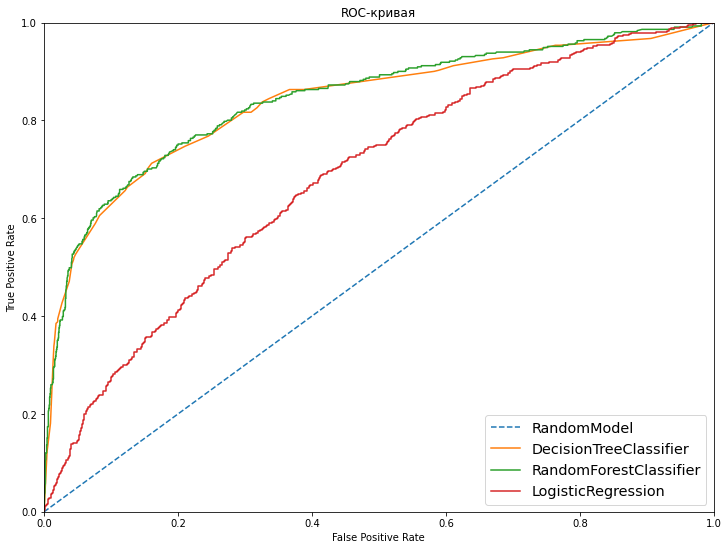

In [25]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


model = DecisionTreeClassifier(random_state=random, max_depth=7, min_samples_leaf=1, min_samples_split=2)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC DecisionTreeClassifier',auc_roc.round(4))
plt.plot(fpr, tpr, label='DecisionTreeClassifier')

model = RandomForestClassifier(random_state=random, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_estimators=5)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC RandomForestClassifier',auc_roc.round(4))
plt.plot(fpr, tpr, label='RandomForestClassifier')

model = LogisticRegression(random_state=random, solver='liblinear')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC LogisticRegression',auc_roc.round(4))
plt.plot(fpr, tpr, label='LogisticRegression')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

По полученным результатам можно заметить, что метрика АUC-ROC лучшая у модели Случайного леса. 

## Вывод

В данных сущестует дисбаланс классов в отношении 1:4.

Возможно он влияет на качество изучаемых моделей.

По полученным моделям можно заметить, что метрика АUC-ROC лучшая у модели Случайного леса, F1 - у дерева решений.


# Улучшение качества модели. Обучение и выбор лучшей модели.


Для борьбы с дисбалансом используем следующие инструменты:

* взвешивание
* upsampling
* downsampling

Изучим возможности моделей по взвешиванию классов.

In [26]:
model = DecisionTreeClassifier(random_state=random, max_depth=7, min_samples_leaf=1, min_samples_split=2, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Решающее дерево')
print('Accuracy', accuracy_score(target_valid, predicted_valid).round(4))
print('Precision', precision_score(target_valid, predicted_valid).round(4))
print('Recall', recall_score(target_valid, predicted_valid).round(4))
print('F1', f1_score(target_valid, predicted_valid).round(4))
print()

model = RandomForestClassifier(random_state=random, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_estimators=5, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Случайный лес')
print('Accuracy', accuracy_score(target_valid, predicted_valid).round(4))
print('Precision', precision_score(target_valid, predicted_valid).round(4))
print('Recall', recall_score(target_valid, predicted_valid).round(4))
print('F1', f1_score(target_valid, predicted_valid).round(4))
print()

model = LogisticRegression(random_state=random, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Логистическая регрессия')
print('Accuracy', accuracy_score(target_valid, predicted_valid).round(4))
print('Precision', precision_score(target_valid, predicted_valid).round(4))
print('Recall', recall_score(target_valid, predicted_valid).round(4))
print('F1', f1_score(target_valid, predicted_valid).round(4))
print()

Решающее дерево
Accuracy 0.7535
Precision 0.4565
Recall 0.7541
F1 0.5687

Случайный лес
Accuracy 0.812
Precision 0.5512
Recall 0.6868
F1 0.6116

Логистическая регрессия
Accuracy 0.7015
Precision 0.3955
Recall 0.7285
F1 0.5127



После взвешивания классов мера F1 самая высокая  у случайного леса. 

Используем метод upsampling для преодоления дисбаланса и протестируем модели еще раз.

In [27]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=random)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(target_upsampled.value_counts())

1    4808
0    4798
Name: exited, dtype: int64


In [28]:
%%time

model = DecisionTreeClassifier(random_state=random, max_depth=7, min_samples_leaf=1, min_samples_split=2)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('Решающее дерево')
print('Accuracy', accuracy_score(target_valid, predicted_valid).round(4))
print('Precision', precision_score(target_valid, predicted_valid).round(4))
print('Recall', recall_score(target_valid, predicted_valid).round(4))
print('F1', f1_score(target_valid, predicted_valid).round(4))
print()

model = RandomForestClassifier(random_state=random, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_estimators=5)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('Случайный лес')
print('Accuracy', accuracy_score(target_valid, predicted_valid).round(4))
print('Precision', precision_score(target_valid, predicted_valid).round(4))
print('Recall', recall_score(target_valid, predicted_valid).round(4))
print('F1', f1_score(target_valid, predicted_valid).round(4))
print()

model = LogisticRegression(random_state=random, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('Логистическая регрессия')
print('Accuracy', accuracy_score(target_valid, predicted_valid).round(4))
print('Precision', precision_score(target_valid, predicted_valid).round(4))
print('Recall', recall_score(target_valid, predicted_valid).round(4))
print('F1', f1_score(target_valid, predicted_valid).round(4))
print()

Решающее дерево
Accuracy 0.757
Precision 0.4611
Recall 0.7564
F1 0.5729

Случайный лес
Accuracy 0.807
Precision 0.5385
Recall 0.7309
F1 0.6201

Логистическая регрессия
Accuracy 0.663
Precision 0.3589
Recall 0.7169
F1 0.4783

CPU times: user 221 ms, sys: 35.9 ms, total: 257 ms
Wall time: 266 ms


После применения метода upsampling (увеличение выборки) наилучшие метрики качества по-прежнему у модели случайного леса.

Используем метод downsampling для преодоления дисбаланса и протестируем модели еще раз.

In [29]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=random)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=random)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=random)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

print(target_downsampled.value_counts())

1    1202
0    1200
Name: exited, dtype: int64


In [30]:
%%time

model = DecisionTreeClassifier(random_state=random, max_depth=7, min_samples_leaf=1, min_samples_split=2)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('Решающее дерево')
print('Accuracy', accuracy_score(target_valid, predicted_valid).round(4))
print('Precision', precision_score(target_valid, predicted_valid).round(4))
print('Recall', recall_score(target_valid, predicted_valid).round(4))
print('F1', f1_score(target_valid, predicted_valid).round(4))
print()

model = RandomForestClassifier(random_state=random, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_estimators=5)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('Случайный лес')
print('Accuracy', accuracy_score(target_valid, predicted_valid).round(4))
print('Precision', precision_score(target_valid, predicted_valid).round(4))
print('Recall', recall_score(target_valid, predicted_valid).round(4))
print('F1', f1_score(target_valid, predicted_valid).round(4))
print()

model = LogisticRegression(random_state=random, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('Логистическая регрессия')
print('Accuracy', accuracy_score(target_valid, predicted_valid).round(4))
print('Precision', precision_score(target_valid, predicted_valid).round(4))
print('Recall', recall_score(target_valid, predicted_valid).round(4))
print('F1', f1_score(target_valid, predicted_valid).round(4))
print()

    
pivot_tab = pd.DataFrame()

Решающее дерево
Accuracy 0.7765
Precision 0.4873
Recall 0.7146
F1 0.5795

Случайный лес
Accuracy 0.746
Precision 0.4476
Recall 0.7633
F1 0.5643

Логистическая регрессия
Accuracy 0.667
Precision 0.3589
Recall 0.6937
F1 0.4731

CPU times: user 133 ms, sys: 52 ms, total: 185 ms
Wall time: 158 ms


Метрики качества самые хорошие на сей раз у дерева решений. 

По итогам сравнения 3 методов преодоления дисбаланса классов победил upsampling.

 Теперь построим ROC-кривую и AUC-ROC для моделей с методом upsampling.

AUC-ROC DecisionTreeClassifier 0.8274441432688738
AUC-ROC RandomForestClassifier 0.8466304072968285
AUC-ROC LogisticRegression 0.7291430988156554


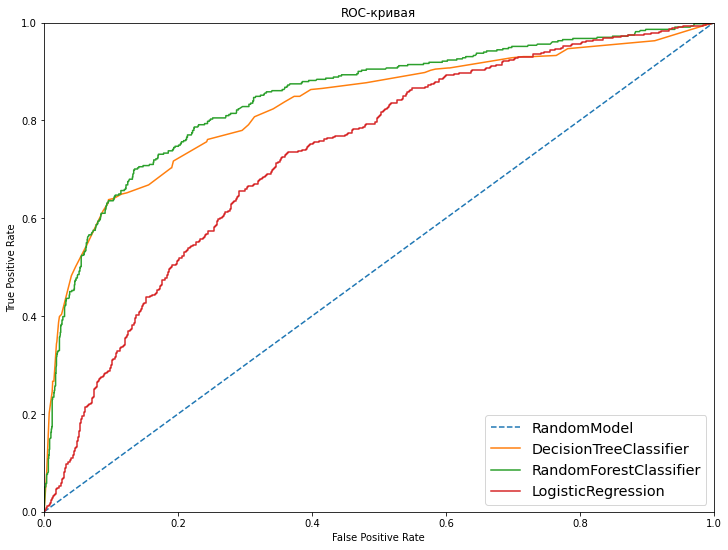

In [31]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


model = DecisionTreeClassifier(random_state=random, max_depth=7, min_samples_leaf=1, min_samples_split=2)
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC DecisionTreeClassifier',auc_roc)
plt.plot(fpr, tpr, label='DecisionTreeClassifier')

model = RandomForestClassifier(random_state=random, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_estimators=5)
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC RandomForestClassifier',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier')

model = LogisticRegression(random_state=random, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC LogisticRegression',auc_roc)
plt.plot(fpr, tpr, label='LogisticRegression')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

## Вывод

После преодоления дисбаланса классов мы получили улучшение метрик качества. Наиболее хорошие метрики (F1, AUC-ROC) - у модели случайного леса, при использовании метода upsampling

# Финальное тестирование

Протестируем финальную модель на тестовой выборке. От дисбаланса классов избавляемся методом upsampled, как показавшим самые лучшие метрики на предыдущем этапе

Гиперпараметры оставляем те, что получены на этапе валидационного тестирования.

In [32]:
model = RandomForestClassifier(random_state=random, max_depth=9, min_samples_leaf=4, min_samples_split=2, n_estimators=5)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
print('Upsampled:')
print('Accuracy', accuracy_score(target_test, predicted_test).round(4))
print('Precision', precision_score(target_test, predicted_test).round(4))
print('Recall', recall_score(target_test, predicted_test).round(4))
print('F1', f1_score(target_test, predicted_test).round(4))
print()

Upsampled:
Accuracy 0.8025
Precision 0.5079
Recall 0.7178
F1 0.5949



Мы видим, что метрики F1, accuracy после финального тестирования соответствуют минимально допустимому порогу.
Проверим метрику AUC-ROC:

AUC-ROC RandomForestClassifier 0.8238317017792005


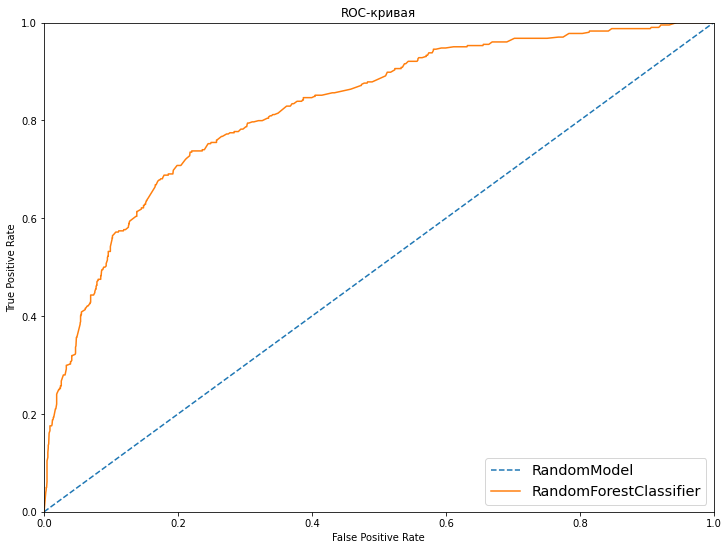

In [33]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


model = RandomForestClassifier(random_state=random, max_depth=8, min_samples_leaf=6, min_samples_split=2, n_estimators=2)
model.fit(features_upsampled, target_upsampled)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC RandomForestClassifier',auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

Значение метрики AUC-ROC составляет 0.82.

## Вывод

После проведения финального тестирования обученной модели с преодолением дисбаланса классов мы получили допустимые результаты, свидетельствующие о том, что модель пригодна к использованию для предсказания оттока клиентов.

# Общий вывод

Accuracy нашей модели 80%. Значение метрики AUC_ROC  - 0.82, F1-мера равна 0.59.

Наша модель проходит тест на адекватность и умеет предсказывать уход клиента лучше, чем случайная модель.
